In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
DEVICE='cuda'

import pandas as pd
import torch
import cv2
import numpy as np
import sys
import math
from pathlib import Path
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from src import config
from src.preprocessing import LumbarDataset, get_aug_test
from src.architecture import LumbarHmModel

from src.postprocessing import topk, get_coordinates_hm, annotation_format, intersection_over_union
from tqdm.notebook import tqdm

In [2]:
data = pd.read_csv(config.PATH_TO_DATA)
path = '../train_data/slices_train/'
with open(config.PATH_TO_ANNOTATION, 'rb') as f:
    annotations = pickle.load(f)

In [3]:
train, test = train_test_split(data, test_size=0.2, random_state=config.SEED)

train_dataset = LumbarDataset(train, tfms=get_aug_test(), train=False)
dataloader_train = DataLoader(train_dataset, batch_size=config.BATCH_SIZE_TRAIN, shuffle=True)

test_dataset = LumbarDataset(test, tfms=get_aug_test(), train=False)
dataloader_val = DataLoader(test_dataset, batch_size=config.BATCH_SIZE_TEST, shuffle=False)

In [4]:
model = LumbarHmModel(encoder = config.ENCODER, decoder = config.DECODER).to(DEVICE)

In [5]:
model.backbone.load_state_dict(torch.load(config.BEST_MODEL)['model_state_dict'])

<All keys matched successfully>

In [6]:
model.eval();

In [ ]:
all_cts = []
xs = []
ys = []
cts_ = []
sources = []
hms = []
metrics = []
bbb = []

for x, y, source_shape, path in tqdm(dataloader_val):
    preds = []
    targets = []
    
    out = model(x.to(DEVICE)).detach().cpu()
    source_shape = np.array(source_shape)
    out_resize = torch.tensor(cv2.resize(out.permute(0,2,3,1)[0].numpy(), (source_shape[1], source_shape[0])).reshape(1,source_shape[0],source_shape[1],5)).permute(0,3,1,2)
    bboxes, cts = get_coordinates_hm(out_resize)
    annot = annotations[path[0].split('/')[-1].split('.')[0]]
    if len(annot) != len(cts):
        xs.append(x)
        ys.append(y)
        cts_.append(cts)
        sources.append(source_shape)
        hms.append(out_resize.detach().cpu().numpy())
        bbb.append(bboxes)
        continue
    outputs, bboxes = annotation_format(bboxes)
    for i in range(len(outputs)):
        pred = np.array(outputs[i][0:2]).flatten()
        target = np.array(annotations[path[0].split('/')[-1].split('.')[0]][i][0:2]).flatten()
        
        preds.append(pred)
        targets.append(target)
        
    iou_= torch.mean(intersection_over_union(torch.tensor(preds), torch.tensor(targets))).item()
    metrics.append(iou_)

  0%|          | 0/120 [00:00<?, ?it/s]

In [27]:
np.mean(metrics)

0.8418001428795593

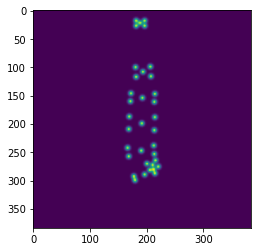

In [47]:
plt.imshow(cv2.resize(np.sum(np.array(ys[i]), axis=1)[0], (sources[i][1], sources[i][0])))
i+=1

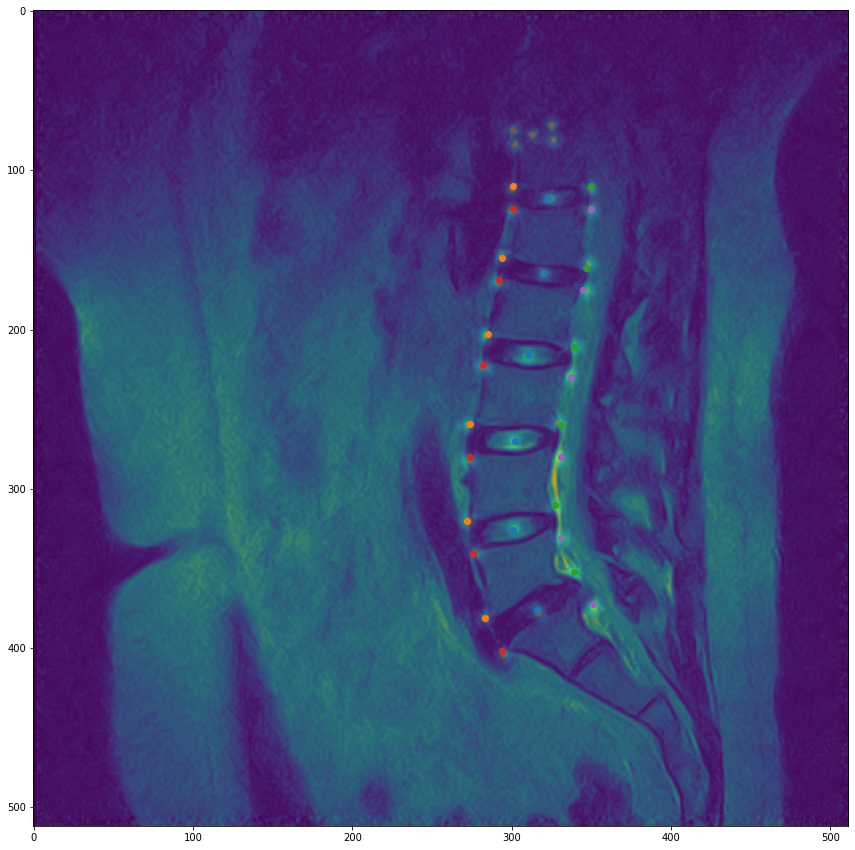

In [64]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.resize(np.array(xs[i][0][0]), (sources[i][1], sources[i][0])))
plt.imshow(cv2.resize(np.sum(np.array(ys[i]), axis=1)[0], (sources[i][1], sources[i][0])), alpha=0.3)
plt.scatter(cts_[i][:,0], cts_[i][:,1])
plt.scatter(bbb[i][:,0,0], bbb[i][:,0,1])
plt.scatter(bbb[i][:,1,0], bbb[i][:,1,1])
plt.scatter(bbb[i][:,2,0], bbb[i][:,2,1])
plt.scatter(bbb[i][:,3,0], bbb[i][:,3,1])
i+=1